# Train Your Very First Pytorch Model!


Let's learn through doing.

In this notebook we will create an image classifier to detect playing cards.

We will tackle this problem in 3 parts:
1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop

Almost every pytorch model training pipeline meets this paradigm.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

System Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch version 2.1.2+cu118
Torchvision version 0.16.2+cu118
Numpy version 1.26.3
Pandas version 2.1.4


# Step 1. Pytorch Dataset (and Dataloader)

Would you learn how to bake a cake without first having the ingredients? No.

The same thing can be said for training a pytorch model without first having the dataset setup correctly.

This is why datasets are important:
- It's an organized way to structure how the data and labels are loaded into the model.
- We can then wrap the dataset in a dataloader and pytorch will handle batching the shuffling the data for us when training the model!

In [2]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

## Create Test Dataset

In [3]:
dataset = PlayingCardDataset(
    data_dir='./cards-image-datasetclassification/train'
)

In [4]:
len(dataset)

7624

41


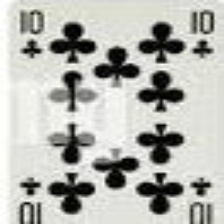

In [5]:
image, label = dataset[6000]
print(label)
image

In [6]:
# Get a dictionary associating target values with folder names
data_dir = './cards-image-datasetclassification/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = './cards-image-datasetclassification/train'
dataset = PlayingCardDataset(data_dir, transform)

In [8]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [9]:
# iterate over dataset
for image, label in dataset:
    break

## Dataloaders

- Batching our dataset
- It's faster to train the model in batches instead of one at a time.

In [10]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [11]:
for images, labels in dataloader:
    break

In [12]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [13]:
labels

tensor([35, 24, 49, 17, 18,  7,  1,  3,  6, 38, 11,  7, 16, 14, 21,  8,  5, 49,
        10, 36, 17, 22,  6, 43, 18, 29, 16,  1, 39, 15, 41, 11])

# Step 2. Pytorch Model

Pytorch datasets have a structured way of organizing your data, pytorch models follow a similar paradigm.
- We could create the model from scratch defining each layer.
- However for tasks like image classification, many of the state of the art architectures are readily available and we can import them from packages like timm.
- Understanding the pytorch model is all about understanding the shape the data is at each layer, and the main one we need to modify for a task is the final layer. Here we have 53 targets, so we will modify the last layer for this.


In [14]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


In [15]:
model = SimpleCardClassifer(num_classes=53)
print(str(model)[:500])

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [16]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

# Step 3. The training loop

- Now that we understand the general paradigm of pytorch datasets and models, we need to create the process of training this model.
- Some things to consider: We want to validate our model on data it has not been trained on, so usually we split our data into a train and validate datasets (I have whole videos on this). This is easy because we can just create two datasets using our existing class.
    - Terms:
        - Epoch: One run through the entire training dataset.
        - Step: One batch of data as defined in our dataloader
- This loop is one you will become familiar with when training models, you load in data to the model in batches - then calculate the loss and perform backpropagation. There are packages that package this for you, but it's good to have at least written it once to understand how it works.
- Two things to select:
    - optimizer, `adam` is the best place to start for most tasks.
    - loss function: What the model will optimize for.


In [17]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


## Setup Datasets

In [19]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = './cards-image-datasetclassification/train/'
valid_folder = './cards-image-datasetclassification/valid/'
test_folder = './cards-image-datasetclassification/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Simple Training Loop

In [20]:
# Simple training loop
num_epochs = 50
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

/home/sadam/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10 - Train loss: 1.5286777648070176, Validation loss: 0.322815706594935


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/10 - Train loss: 0.5579565506729475, Validation loss: 0.27660127720742855


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/10 - Train loss: 0.31177521590045715, Validation loss: 0.17454247171024106


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/10 - Train loss: 0.2535231995698287, Validation loss: 0.12991517062457103


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/10 - Train loss: 0.1841374357257347, Validation loss: 0.19197267631314835


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/10 - Train loss: 0.17128942567163224, Validation loss: 0.14918314353475032


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/10 - Train loss: 0.13502103917238156, Validation loss: 0.10516214232962086


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/10 - Train loss: 0.118143666204327, Validation loss: 0.26191907648770313


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/10 - Train loss: 0.113760302874288, Validation loss: 0.12085756892865558


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/10 - Train loss: 0.10133775069738923, Validation loss: 0.16282133357423656


# Visualize Losses

We can plot our training and validation loss through this training, usually we do this at the end of each epoch. We see that our accuracy on the validation dataset is `x`! There are a LOT more things to learn about that can drastically improve how to train a model which I will cover in future videos, but this should give you a good start!



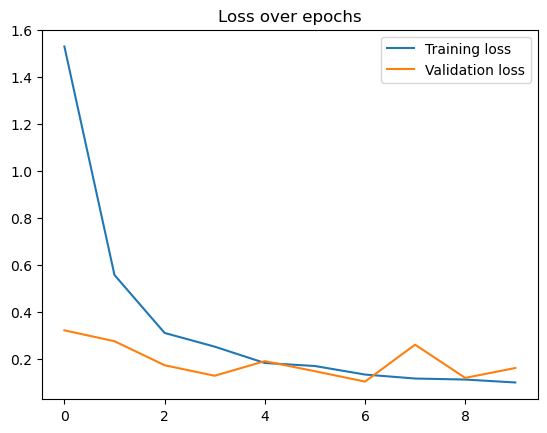

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# **Bonus:** Evaluating the Results



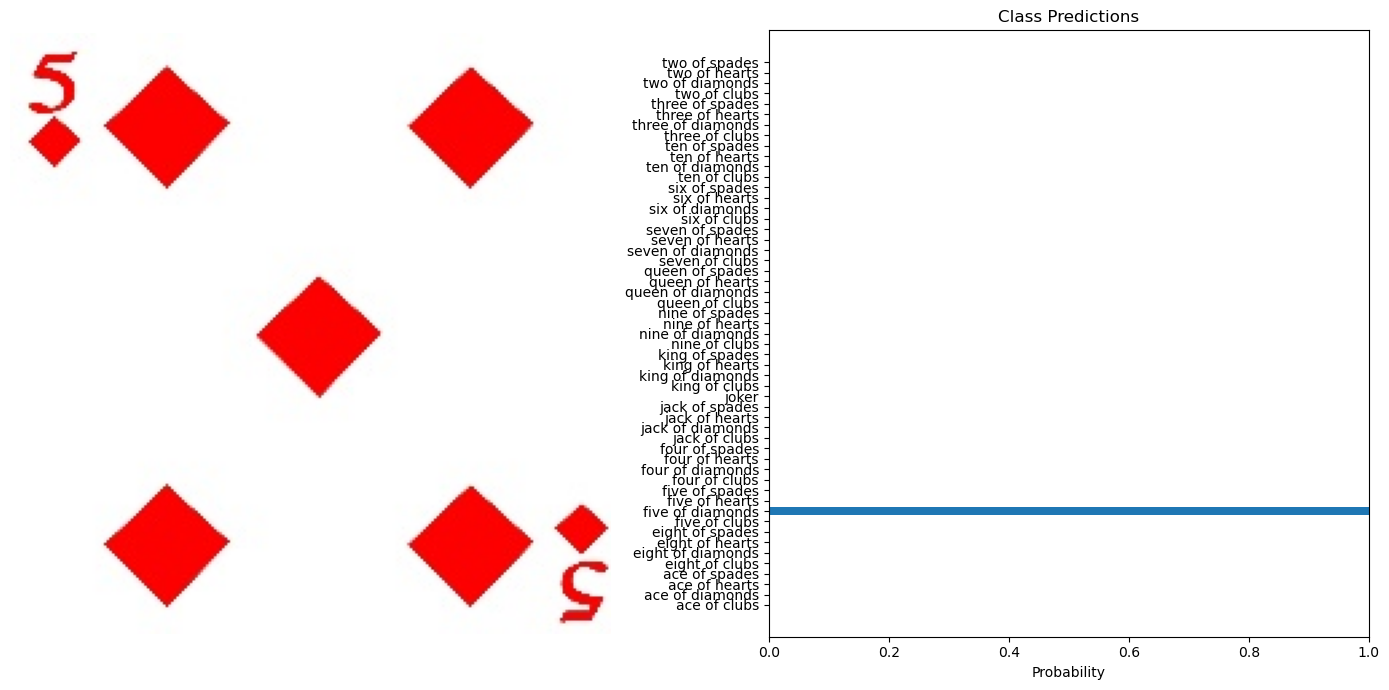

In [22]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "./cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

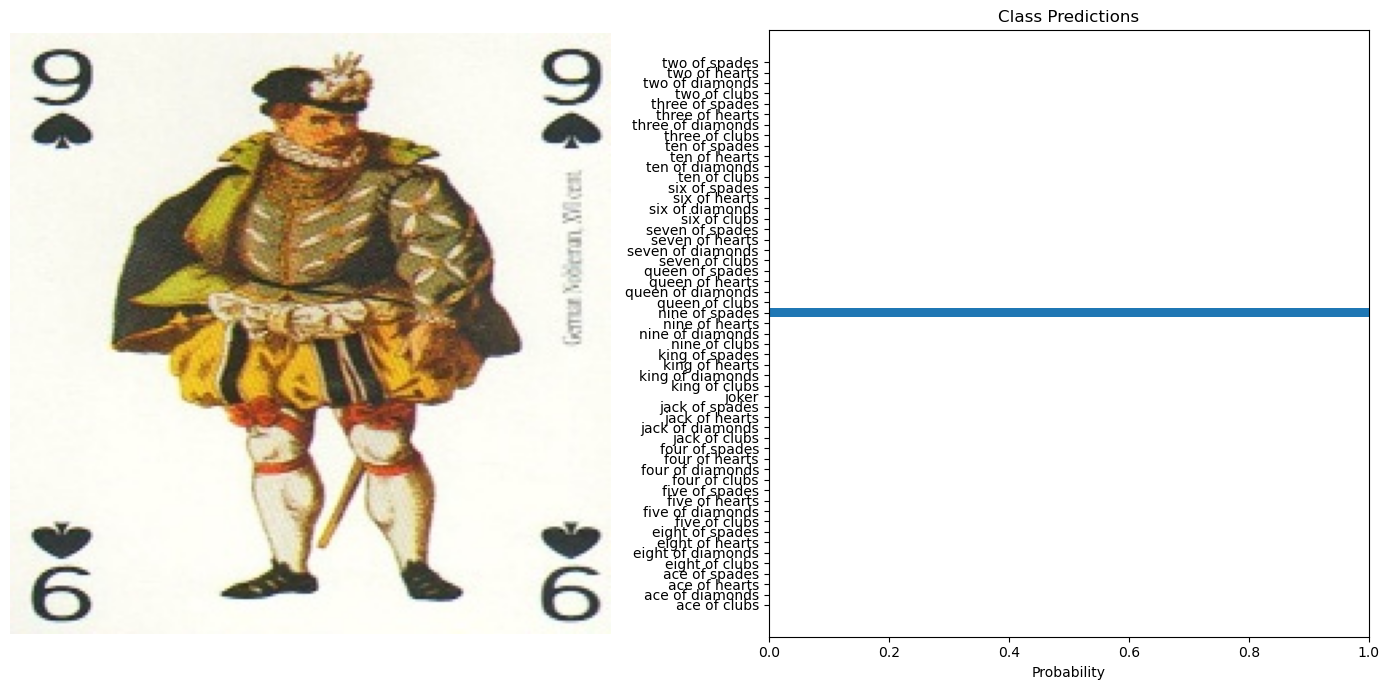

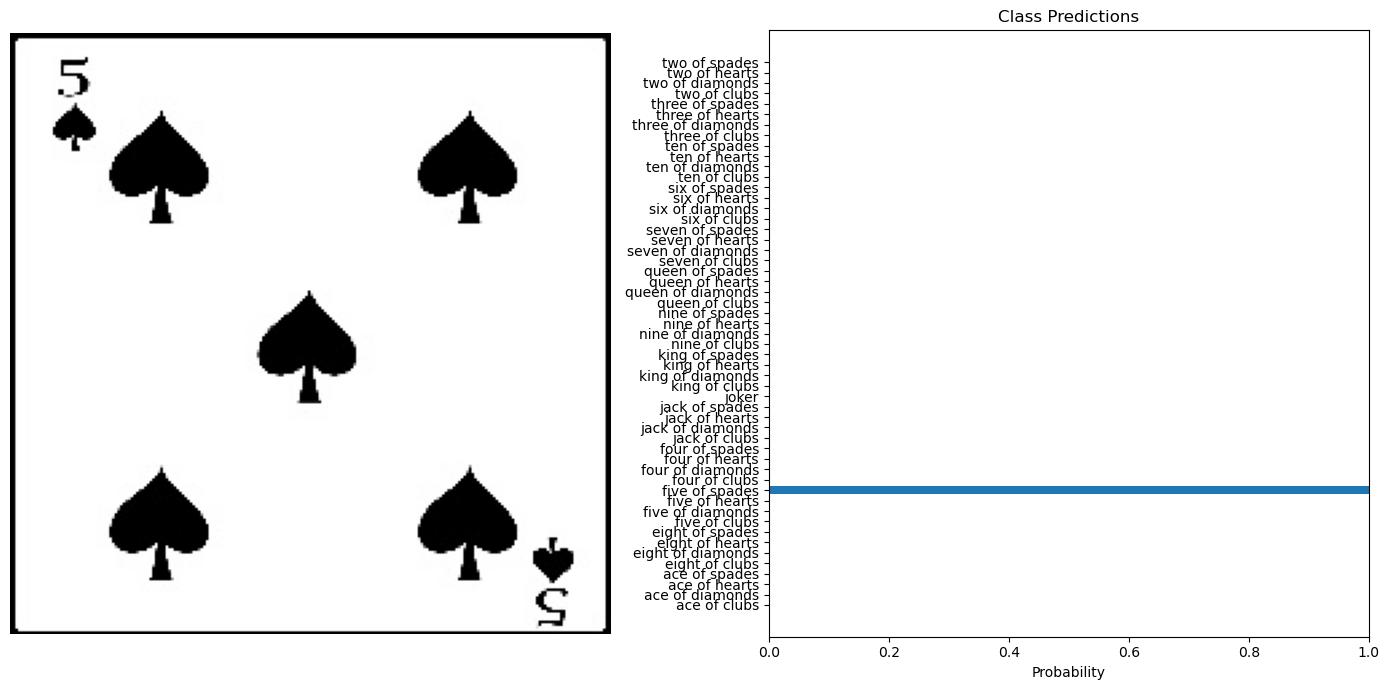

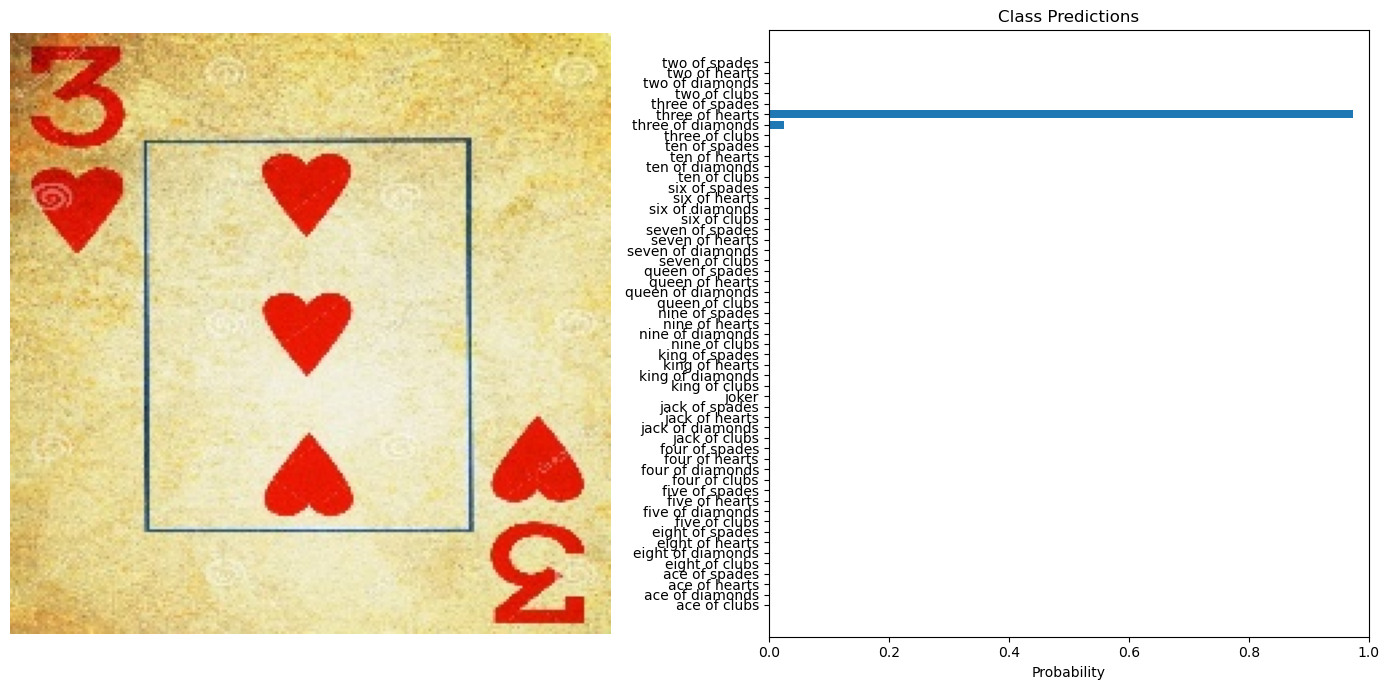

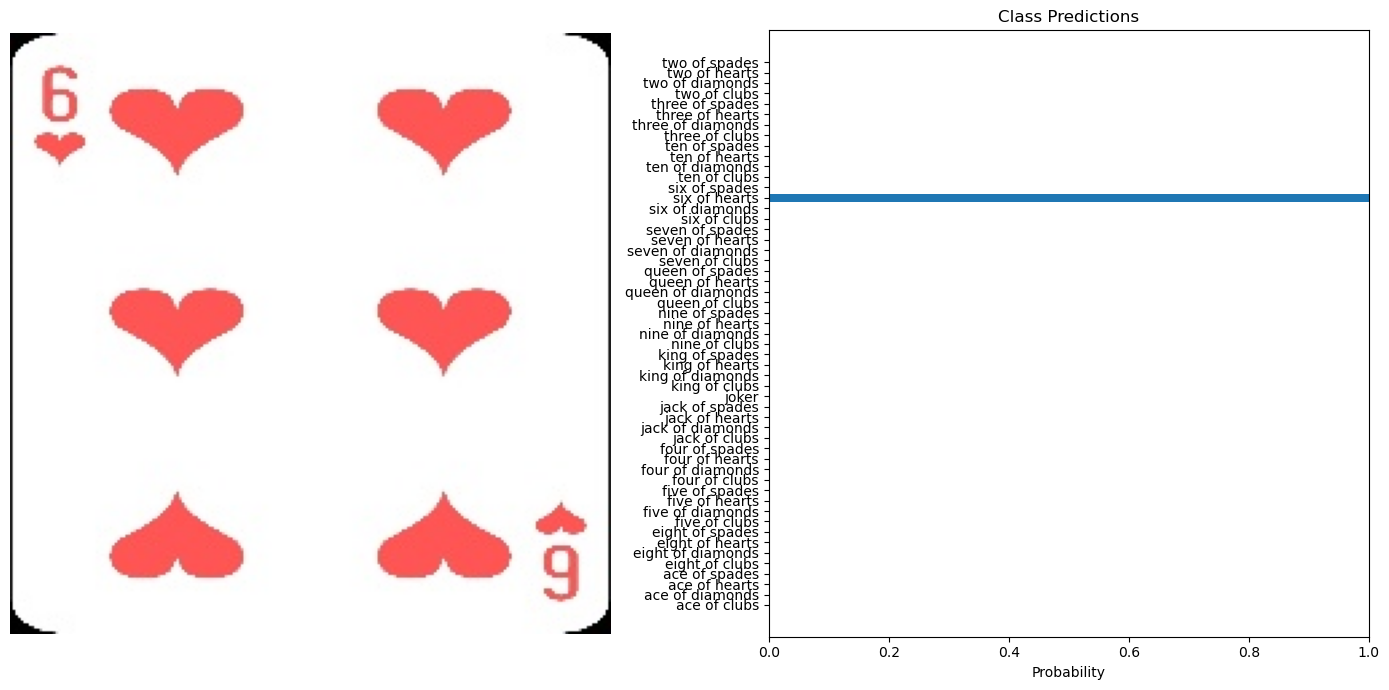

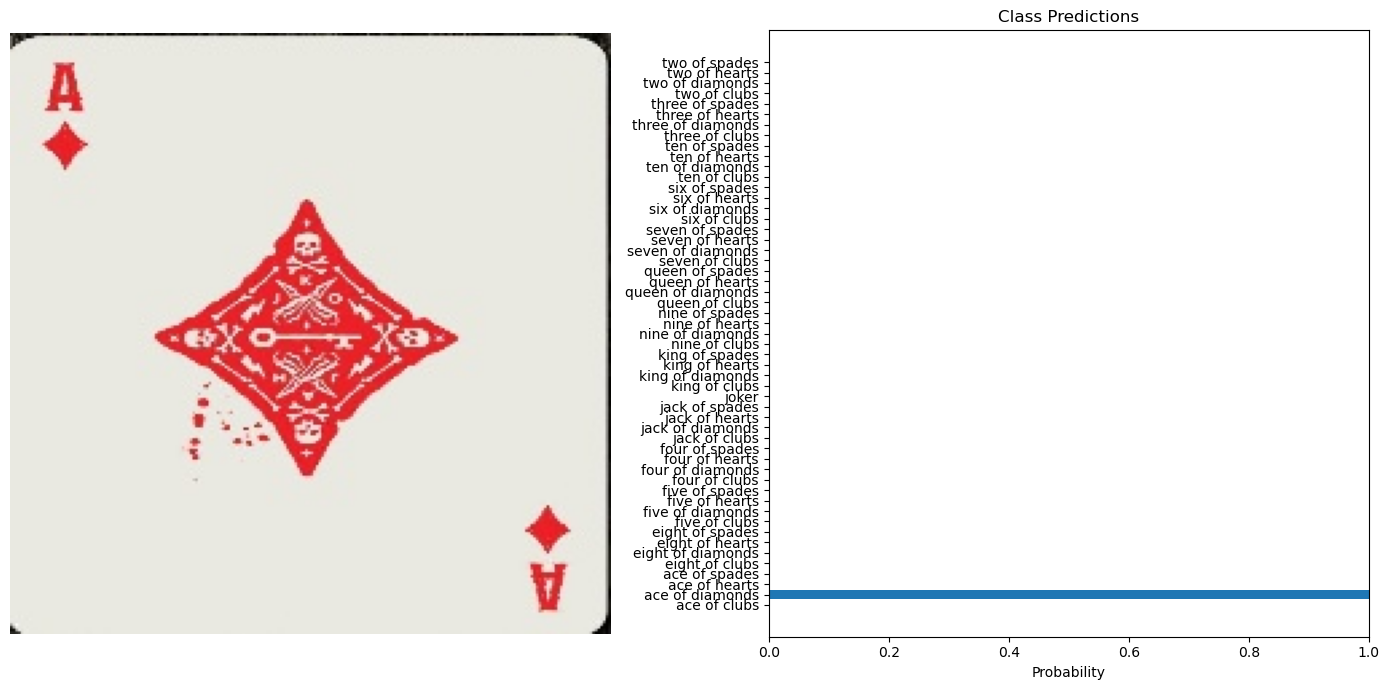

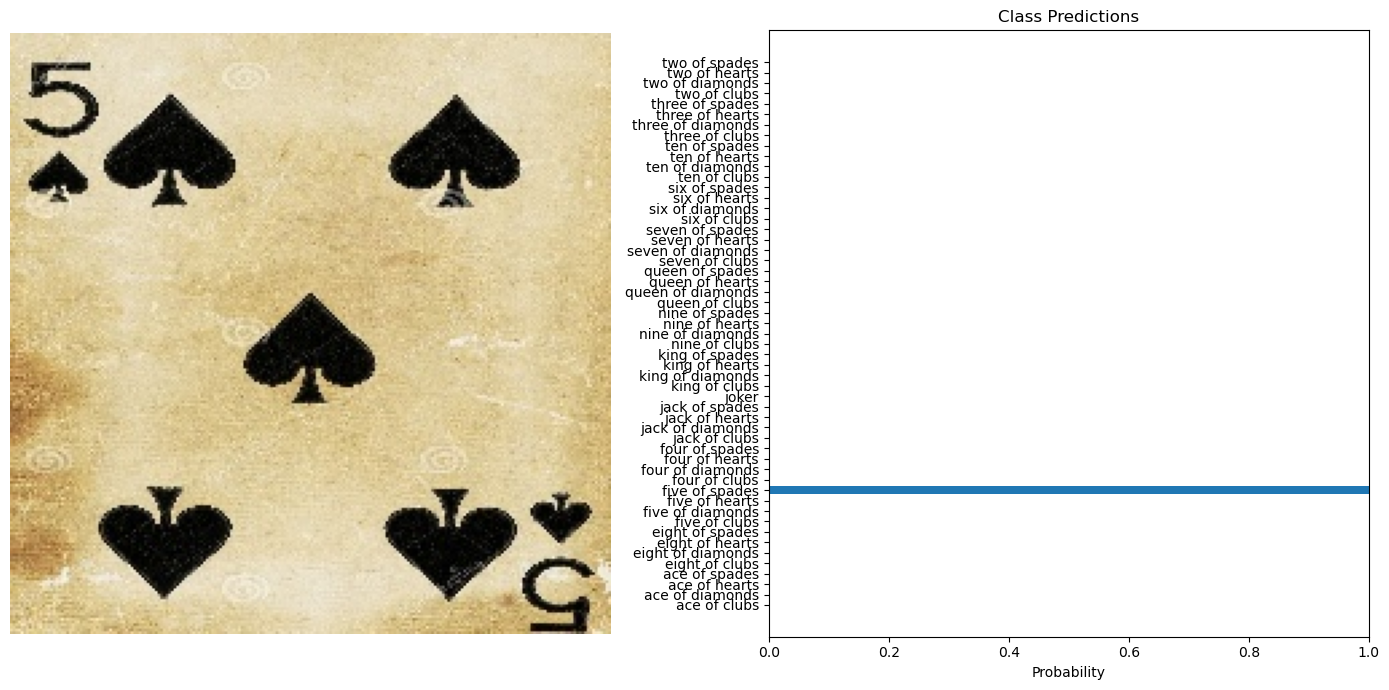

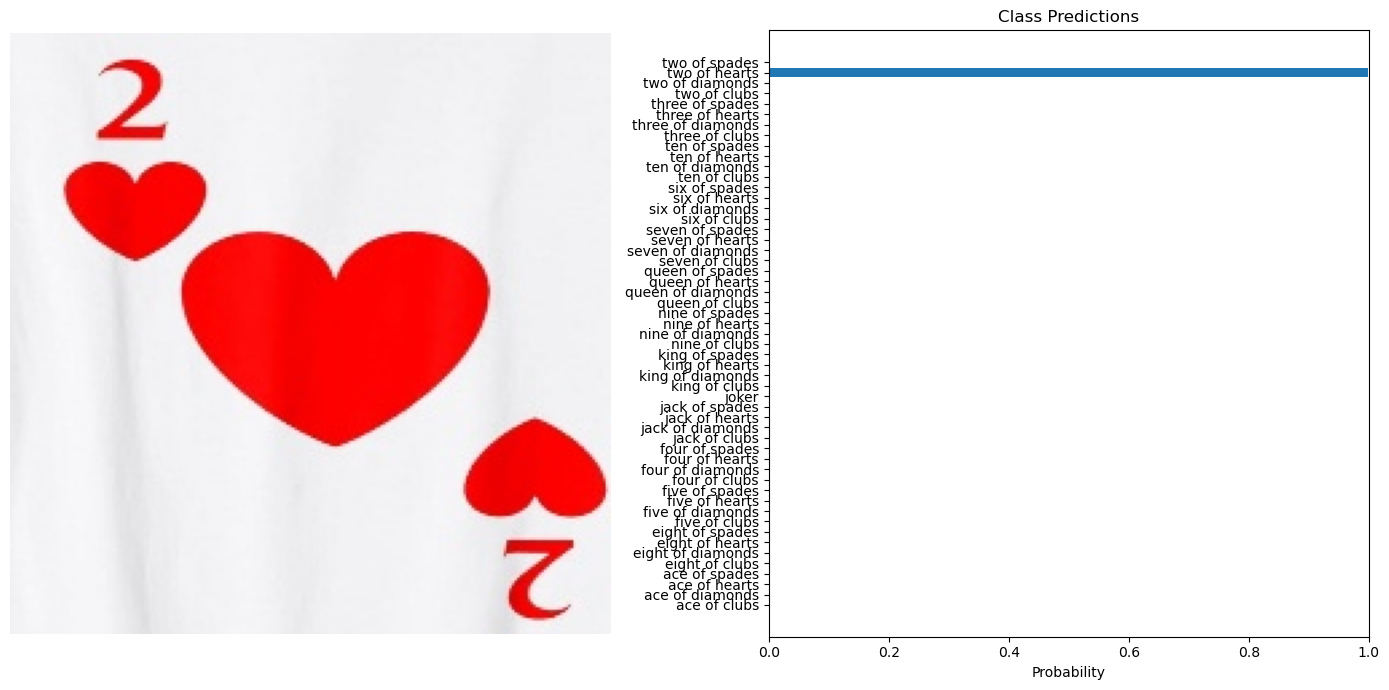

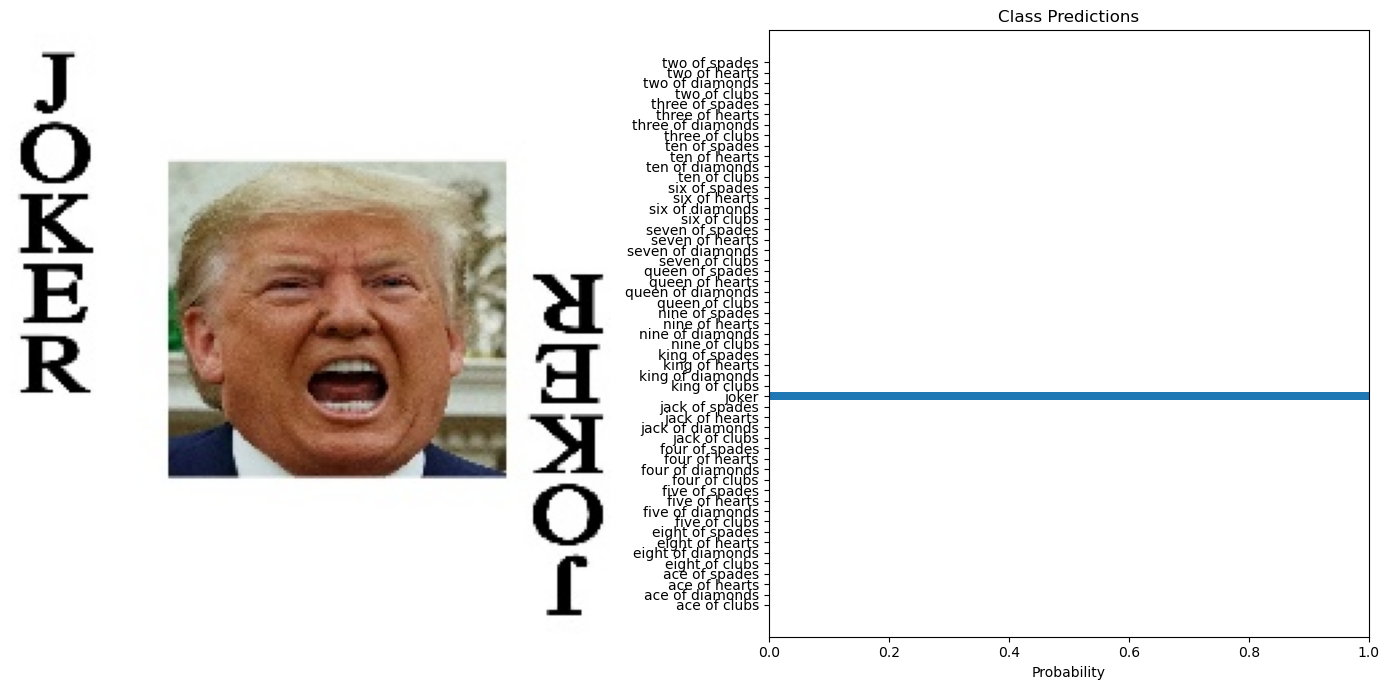

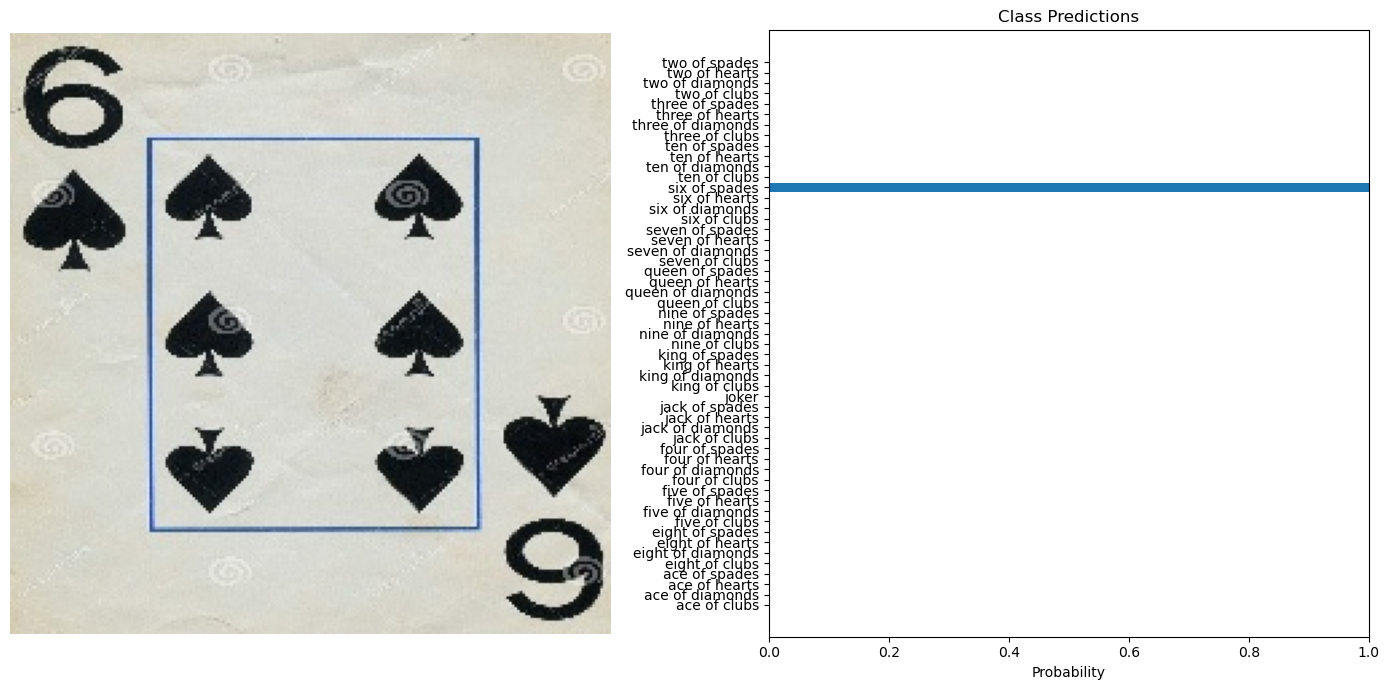

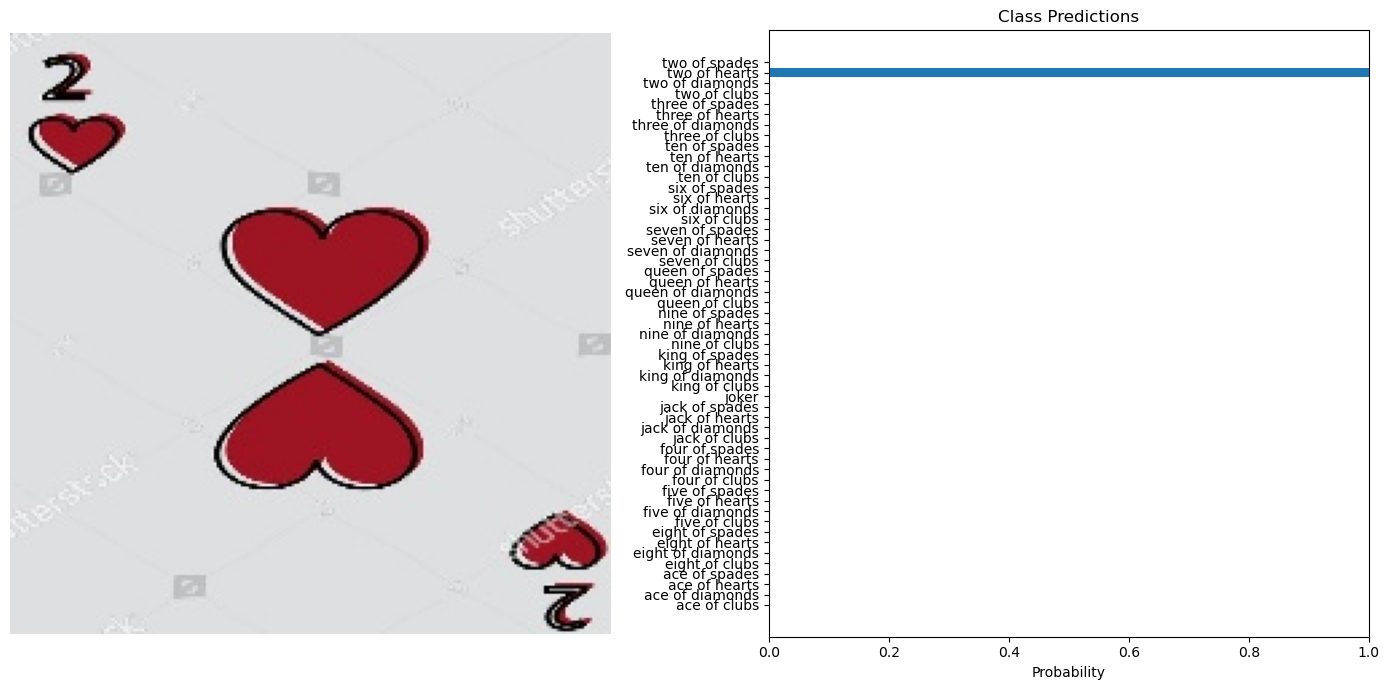

In [23]:
from glob import glob
test_images = glob('./cards-image-datasetclassification/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

# Todo

- Calculate the accuracy of our model on the validation and test set.